In [2]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

# Load

In [3]:
df = pd.read_csv('../data/telco_churn_numeric.csv')

In [9]:
target = df['Churn']
train_cols = [col for col in df.columns[1:] if col != 'Churn']
train = df[train_cols]

In [95]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    # Print Report
    print('Grid Scores: \n')
    pp.pprint(results)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

# Modeling

## Tuning

### Naive Bayes

In [48]:
model = GaussianNB()

bayes_gsearch = grid_classifier(model, train, target)

Seconds to fit: 0.30
Grid Scores: 

{'mean_fit_time': array([0.01380115]),
 'mean_score_time': array([0.00394545]),
 'mean_test_score': array([0.82736941]),
 'mean_train_score': array([0.82826034]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.83927769]),
 'split0_train_score': array([0.82530001]),
 'split1_test_score': array([0.83473352]),
 'split1_train_score': array([0.82606619]),
 'split2_test_score': array([0.82014389]),
 'split2_train_score': array([0.83041644]),
 'split3_test_score': array([0.82265881]),
 'split3_train_score': array([0.82995254]),
 'split4_test_score': array([0.82002271]),
 'split4_train_score': array([0.82956653]),
 'std_fit_time': array([0.00440389]),
 'std_score_time': array([0.00109788]),
 'std_test_score': array([0.00805512]),
 'std_train_score': array([0.00213524])}
Best Model Parameters: {}
Best Model Score: 0.8274


---
### Logistic Regression

Seconds to fit: 1.40
Grid Scores: 

{'mean_fit_time': array([0.05211391, 0.07097368, 0.09812284, 0.10274997, 0.11830993,
       0.12663307, 0.09241762]),
 'mean_score_time': array([0.00799255, 0.00268583, 0.00589919, 0.00613723, 0.0054245 ,
       0.00322566, 0.00639496]),
 'mean_test_score': array([0.81696332, 0.84044096, 0.84353222, 0.84358228, 0.84354451,
       0.84354709, 0.84354812]),
 'mean_train_score': array([0.81744732, 0.84212766, 0.84603509, 0.84626347, 0.8462681 ,
       0.84627104, 0.84627152]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 0.001},
            {'C': 0.01},
            {'C': 0.1},
            {'C': 1.0},
            {'C': 10.0},
            {'C': 100.0},
            {'C': 1000.0}],
 'rank_test_score': array([7, 6, 5, 1, 4, 3, 2], dtype=int32),
 'split0_test_score': array([0.82601721, 0.851388

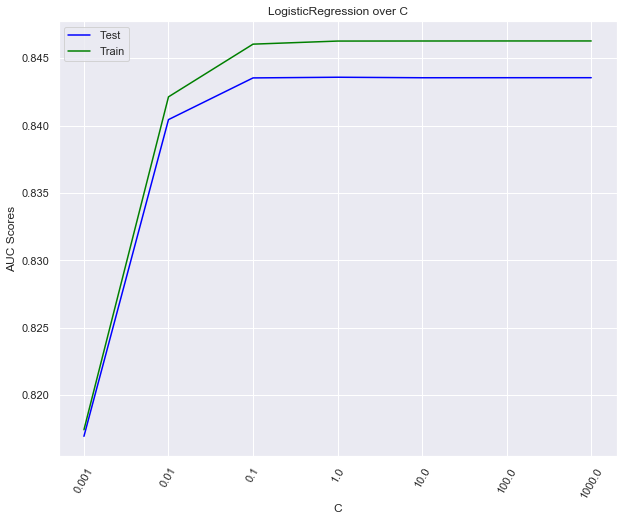

In [96]:
model = LogisticRegression()

parameters = {'C': np.logspace(-3, 3, 7)}

LogReg_gsearch = grid_classifier(model, train, target, parameters)

---
### KNN

Seconds to fit: 8.67
Grid Scores: 

{'mean_fit_time': array([0.01848631, 0.01598086, 0.01499743, 0.01940618, 0.02213016,
       0.01950164, 0.03941998, 0.03115621, 0.02130246, 0.02008362,
       0.02011857, 0.01714444, 0.01667743, 0.0159451 , 0.01474319,
       0.01679978, 0.02240186, 0.01482139, 0.01559596]),
 'mean_score_time': array([0.02787619, 0.03074164, 0.02992282, 0.04376822, 0.04720612,
       0.04958954, 0.07734194, 0.07300739, 0.05513749, 0.08089046,
       0.06868339, 0.07559652, 0.08147836, 0.06984396, 0.06236682,
       0.06929545, 0.07714291, 0.07009168, 0.07238722]),
 'mean_test_score': array([0.77642964, 0.78466428, 0.79102382, 0.79016556, 0.79051113,
       0.78741346, 0.78472692, 0.78316572, 0.78097912, 0.77886248,
       0.77771968, 0.77630676, 0.77422146, 0.77377727, 0.77291198,
       0.77264508, 0.77172797, 0.77100674, 0.77093043]),
 'mean_train_score': array([0.85880197, 0.84391951, 0.83522275, 0.82970242, 0.82218595,
       0.81648546, 0.81061505, 0.80689622, 0

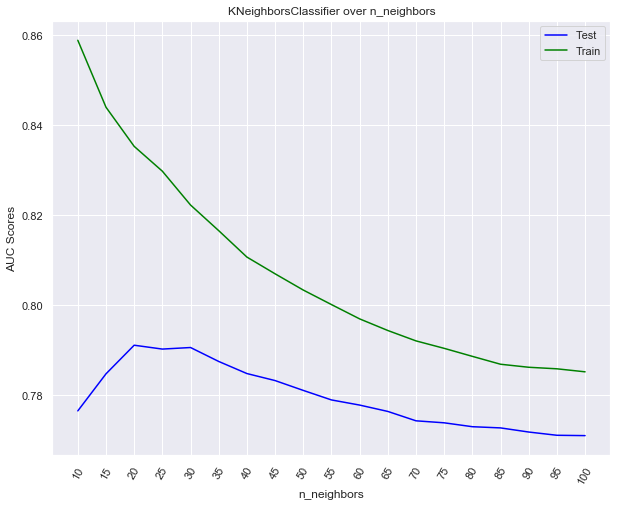

In [97]:
model = KNeighborsClassifier()

parameters = {'n_neighbors': np.arange(10, 101, 5)}

knn_gsearch = grid_classifier(model, train, target, parameters)

---
### Random Forest
#### Benchmark

Seconds to fit: 0.50
Grid Scores: 

{'mean_fit_time': array([0.08834395]),
 'mean_score_time': array([0.00792413]),
 'mean_test_score': array([0.79607635]),
 'mean_train_score': array([0.99879762]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.81055568]),
 'split0_train_score': array([0.9987077]),
 'split1_test_score': array([0.80274096]),
 'split1_train_score': array([0.99873275]),
 'split2_test_score': array([0.77581312]),
 'split2_train_score': array([0.99893201]),
 'split3_test_score': array([0.78404247]),
 'split3_train_score': array([0.99866188]),
 'split4_test_score': array([0.80724535]),
 'split4_train_score': array([0.99895373]),
 'std_fit_time': array([0.00972245]),
 'std_score_time': array([0.00347698]),
 'std_test_score': array([0.01366979]),
 'std_train_score': array([0.00012095])}
Best Model Parameters: {}
Best Model Score: 0.7961


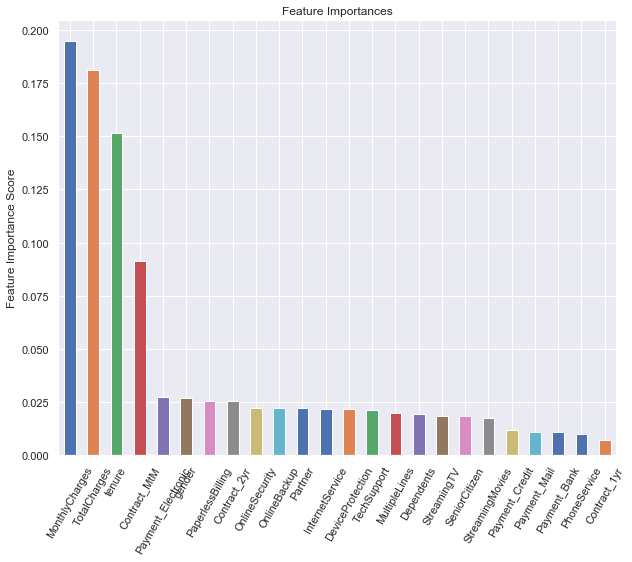

In [98]:
model = RandomForestClassifier(random_state=42)

rfc_gsearch = grid_classifier(model, train, target, feat_imp=True)

#### N_Estimators
I don't want to overfit, so I'll pick a small number for now and max it out after other features are trained.

Seconds to fit: 15.69
Grid Scores: 

{'mean_fit_time': array([0.09605732, 0.15489783, 0.27079635, 0.2295567 , 0.28254356,
       0.30959644, 0.35150924, 0.40231614, 0.43460593, 0.49307876,
       0.51746631, 0.56319547, 0.59283605, 0.63915477, 0.68564234,
       0.74298539, 0.79138417, 0.8103621 , 0.80596008]),
 'mean_score_time': array([0.00867157, 0.01230445, 0.0139976 , 0.01404705, 0.01813116,
       0.01865616, 0.02218742, 0.02459183, 0.0257576 , 0.03161483,
       0.0315063 , 0.03160248, 0.03613615, 0.03790617, 0.04066849,
       0.03970499, 0.04986129, 0.0539948 , 0.04635243]),
 'mean_test_score': array([0.79607635, 0.80612029, 0.81055148, 0.81289937, 0.81514917,
       0.81569944, 0.81758026, 0.8188459 , 0.81981939, 0.82101811,
       0.8213294 , 0.8217809 , 0.82224201, 0.82243358, 0.82286758,
       0.82310505, 0.82318892, 0.82344476, 0.82368849]),
 'mean_train_score': array([0.99879762, 0.99959303, 0.99978188, 0.9998847 , 0.99992403,
       0.99994926, 0.99995918, 0.99996371, 

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

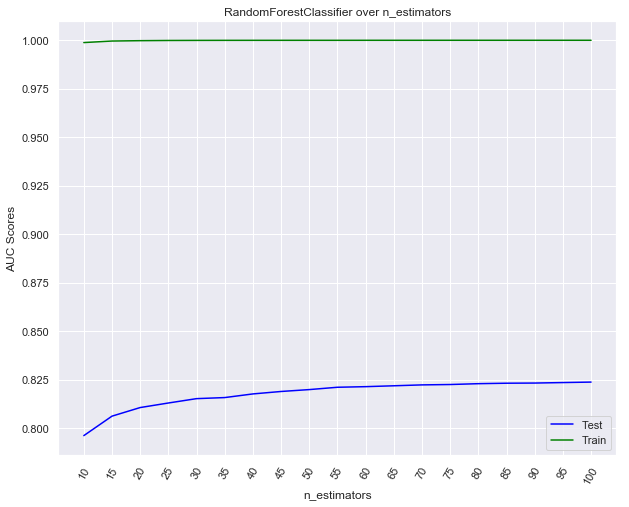

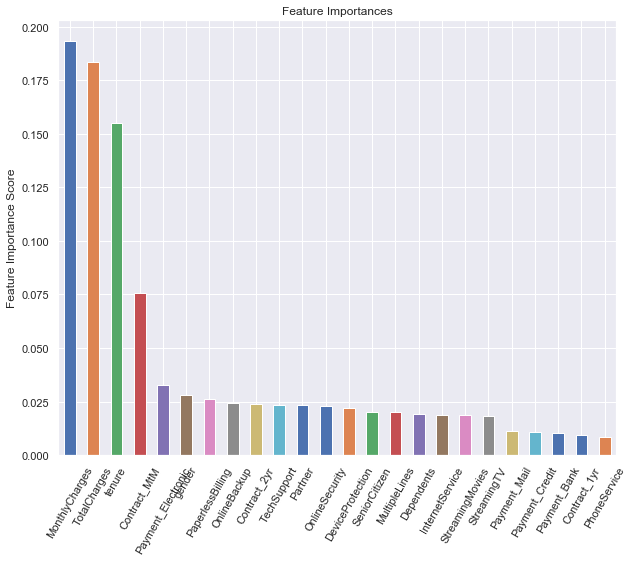

In [100]:
model = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': np.arange(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth

Seconds to fit: 1.72
Grid Scores: 

{'mean_fit_time': array([0.07252092, 0.07460685, 0.12886243, 0.13677521, 0.11525111,
       0.10422354, 0.10159512]),
 'mean_score_time': array([0.00680866, 0.00858221, 0.01512513, 0.0081172 , 0.01109009,
       0.01138172, 0.0079165 ]),
 'mean_test_score': array([0.83058063, 0.83570142, 0.83926243, 0.8416026 , 0.84137864,
       0.84058048, 0.83649278]),
 'mean_train_score': array([0.83585914, 0.84487984, 0.85442931, 0.86601411, 0.88082955,
       0.9006513 , 0.92272714]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([7, 6, 4, 1, 2, 3, 5], dtype=int32),
 'split0_test_score': array([0.

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

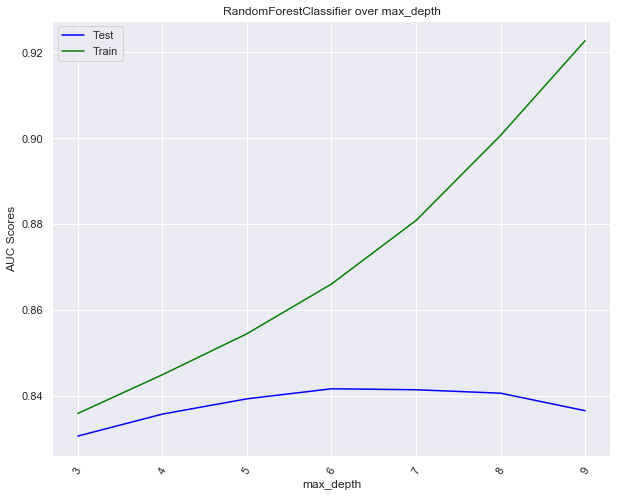

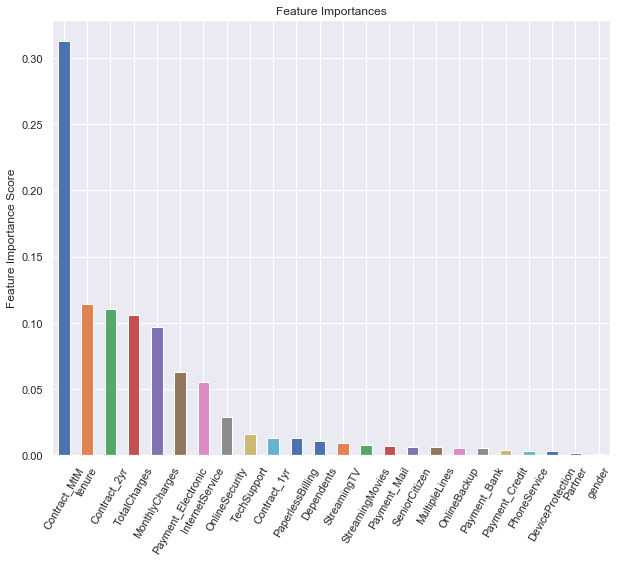

In [101]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
)

parameters = {'max_depth': list(range(3, 10))}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Split

In [122]:
np.linspace(2, 20, 10)

array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

Seconds to fit: 3.77
Grid Scores: 

{'mean_fit_time': array([0.08722005, 0.08486304, 0.082198  , 0.07488046, 0.09452314,
       0.08041301, 0.08018498, 0.0793819 , 0.08533239, 0.08748364,
       0.09024653, 0.07947664, 0.08877683, 0.09285922, 0.10525389,
       0.08837419, 0.08293014, 0.09461989, 0.09876513, 0.07887082,
       0.08050342, 0.07936001, 0.06897607]),
 'mean_score_time': array([0.00865207, 0.00635929, 0.00634408, 0.00595312, 0.00713744,
       0.00707898, 0.01132975, 0.00857019, 0.00637097, 0.00849152,
       0.00786529, 0.00804548, 0.00750952, 0.00808496, 0.00843592,
       0.0070334 , 0.00599599, 0.00895133, 0.00775208, 0.00584517,
       0.00675693, 0.0059073 , 0.00460029]),
 'mean_test_score': array([0.8416026 , 0.84208854, 0.84198251, 0.84214852, 0.84242866,
       0.84221081, 0.84176132, 0.84169394, 0.84163502, 0.84083814,
       0.84083395, 0.84121791, 0.84143472, 0.84076288, 0.84102734,
       0.84131567, 0.84149647, 0.84177297, 0.84226612, 0.84215757,
       0.842

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(2, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

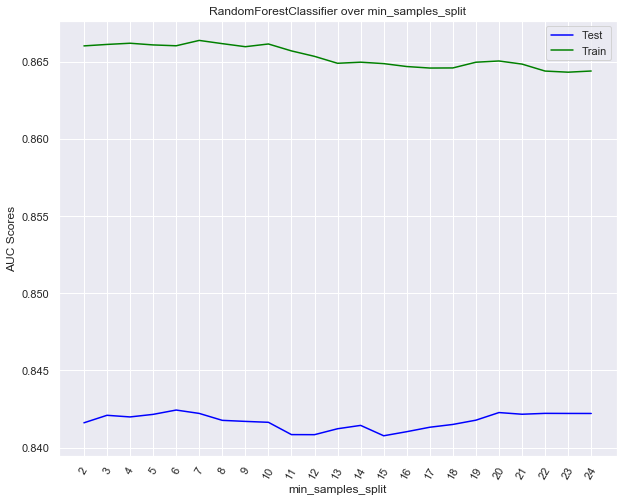

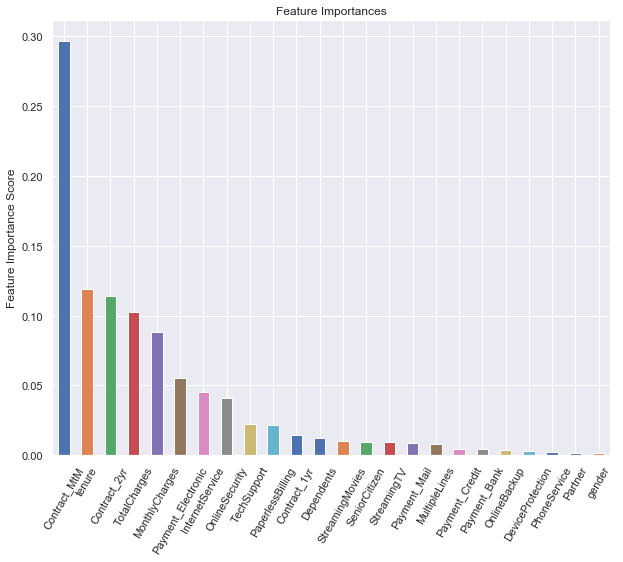

In [126]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6
)

parameters = {'min_samples_split': range(2, 25)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Leaf

Seconds to fit: 3.25
Grid Scores: 

{'mean_fit_time': array([0.0905828 , 0.08700042, 0.08206306, 0.08026495, 0.10032282,
       0.08397064, 0.08654199, 0.079178  , 0.08744779, 0.0834507 ,
       0.08418713, 0.0834362 , 0.08498282, 0.0880815 , 0.07487206,
       0.07831264, 0.08205037, 0.08118606, 0.07669258, 0.06783376]),
 'mean_score_time': array([0.0074964 , 0.00651622, 0.00645704, 0.00690799, 0.00887637,
       0.00733089, 0.00826774, 0.00594945, 0.00629025, 0.00729012,
       0.00909538, 0.00617361, 0.00621147, 0.00613089, 0.00633378,
       0.00596504, 0.00603209, 0.00706434, 0.00621595, 0.00463176]),
 'mean_test_score': array([0.84242866, 0.84270666, 0.84312868, 0.84266665, 0.84227623,
       0.84055308, 0.84055646, 0.84033134, 0.84225948, 0.84223108,
       0.84144082, 0.84247839, 0.84268035, 0.84175002, 0.84189607,
       0.84254468, 0.84253274, 0.84178912, 0.84109515, 0.84204681]),
 'mean_train_score': array([0.86602157, 0.86592184, 0.86521538, 0.86513692, 0.8646233 ,
       0

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(1, 21)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

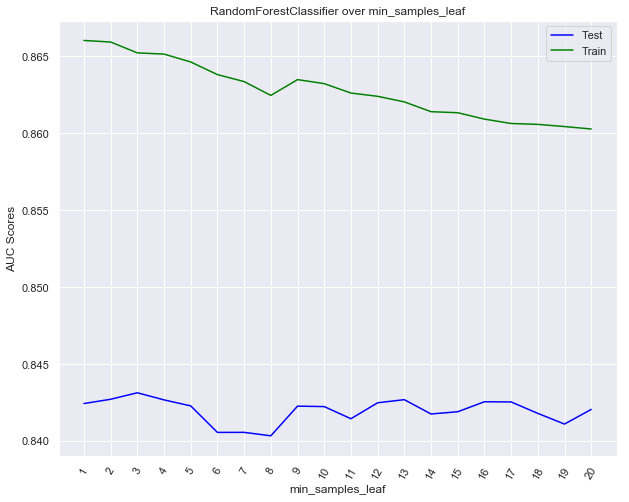

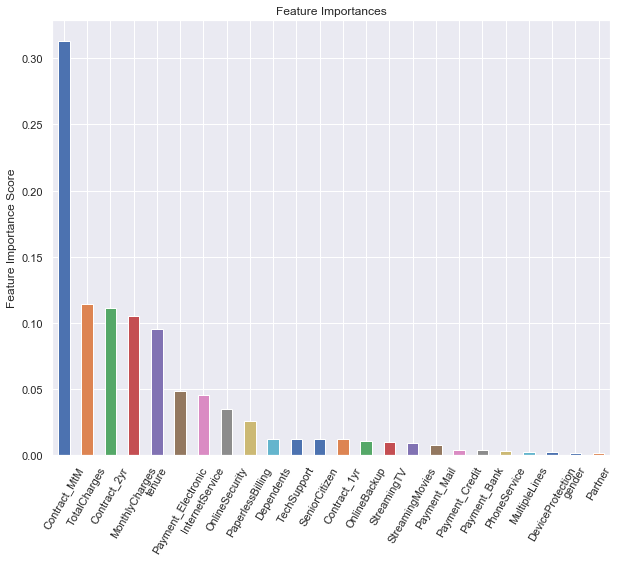

In [127]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6
)

parameters = {'min_samples_leaf': range(1, 21)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Features

Seconds to fit: 1.51
Grid Scores: 

{'mean_fit_time': array([0.08252807, 0.08263445, 0.0900074 , 0.10452113, 0.11682334,
       0.11361504, 0.11058149]),
 'mean_score_time': array([0.00844784, 0.00666351, 0.00747261, 0.00709081, 0.00880494,
       0.00861077, 0.00473866]),
 'mean_test_score': array([0.8397672 , 0.84312868, 0.84282756, 0.84229548, 0.84259941,
       0.84147296, 0.8421002 ]),
 'mean_train_score': array([0.86157853, 0.86521538, 0.86679717, 0.86840708, 0.87051435,
       0.8711333 , 0.87268073]),
 'param_max_features': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 3},
            {'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([7, 1, 2, 4, 3, 6, 5], dtype=int32),
 'split

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

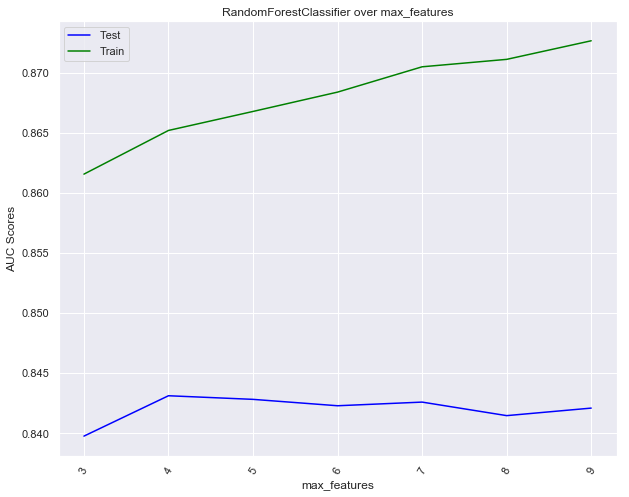

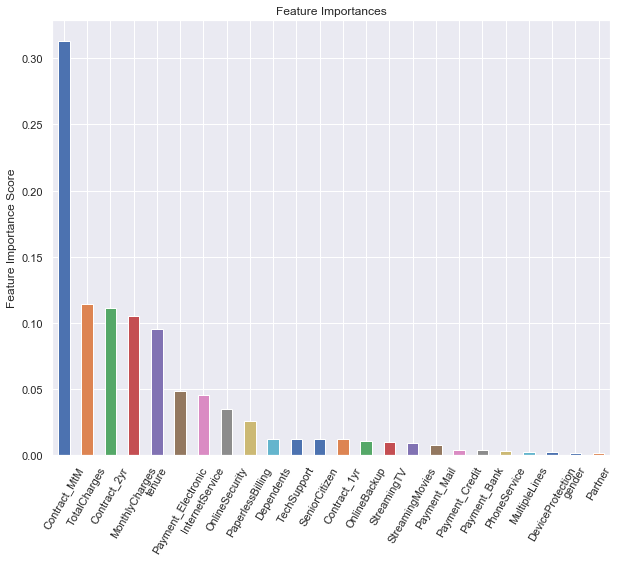

In [129]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3
)

parameters = {'max_features': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max out trees

Seconds to fit: 44.79
Grid Scores: 

{'mean_fit_time': array([0.03614802, 0.05891938, 0.11904988, 0.12700481, 0.15962024,
       0.19696298, 0.24460845, 0.39956269, 0.44951701, 0.39135685,
       0.37371359, 0.77711225, 0.92123442, 1.01667695, 0.83307991,
       0.66762643, 0.73610249, 0.62678599, 0.58853717, 0.67044458,
       0.6481111 , 0.66192775, 0.62157364, 0.77057505, 0.75730348,
       0.75447497, 0.78696451, 0.89698567, 1.52480173, 1.41225567,
       0.95762358, 0.88676414, 0.89328403, 0.94647918, 0.96724505,
       1.00250111, 1.03262806, 1.05664458, 1.07768898, 1.02514076]),
 'mean_score_time': array([0.00423584, 0.00548034, 0.00945082, 0.01008086, 0.01082234,
       0.01211591, 0.03080268, 0.03070164, 0.02622437, 0.01962447,
       0.03667545, 0.0578392 , 0.06105762, 0.0576046 , 0.05189762,
       0.05487528, 0.05525723, 0.03718491, 0.030128  , 0.03808131,
       0.04180818, 0.03894091, 0.03868222, 0.04286914, 0.04477124,
       0.04063606, 0.04193201, 0.06310797, 0.0827204

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

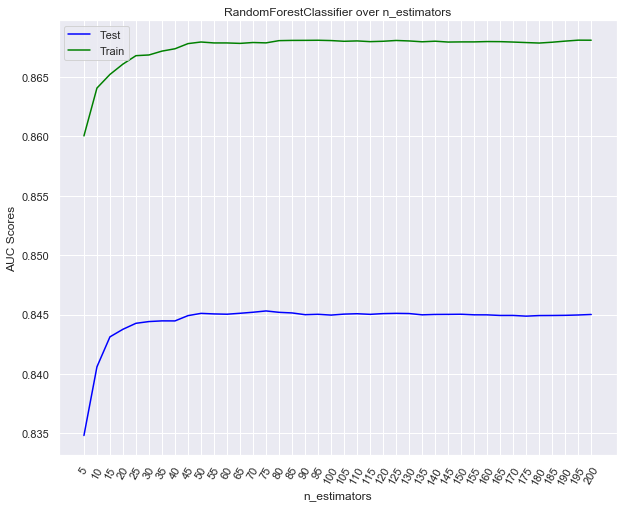

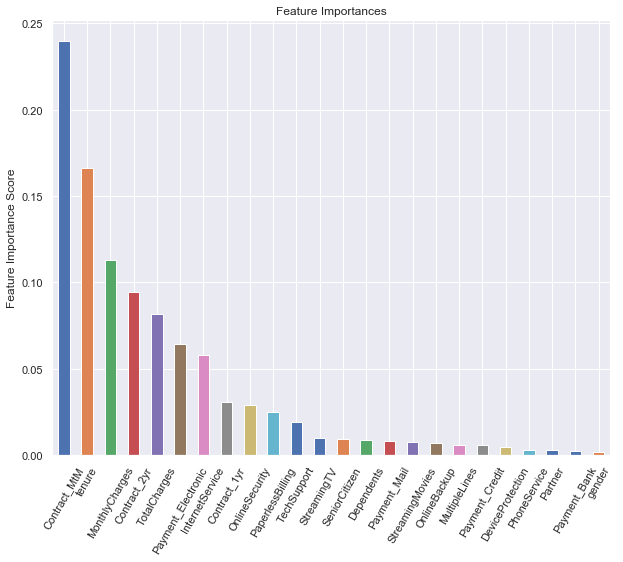

In [130]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=15,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=4
)

parameters = {'n_estimators': np.arange(5, 201, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Final RFC Model

Seconds to fit: 1.02
Grid Scores: 

{'mean_fit_time': array([0.27961979]),
 'mean_score_time': array([0.01993666]),
 'mean_test_score': array([0.84510408]),
 'mean_train_score': array([0.86794509]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85928725]),
 'split0_train_score': array([0.86553891]),
 'split1_test_score': array([0.84999354]),
 'split1_train_score': array([0.86546037]),
 'split2_test_score': array([0.83194993]),
 'split2_train_score': array([0.87163792]),
 'split3_test_score': array([0.84000749]),
 'split3_train_score': array([0.86951124]),
 'split4_test_score': array([0.84428104]),
 'split4_train_score': array([0.86757698]),
 'std_fit_time': array([0.03118499]),
 'std_score_time': array([0.00479176]),
 'std_test_score': array([0.00921817]),
 'std_train_score': array([0.0023744])}
Best Model Parameters: {}
Best Model Score: 0.8451


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

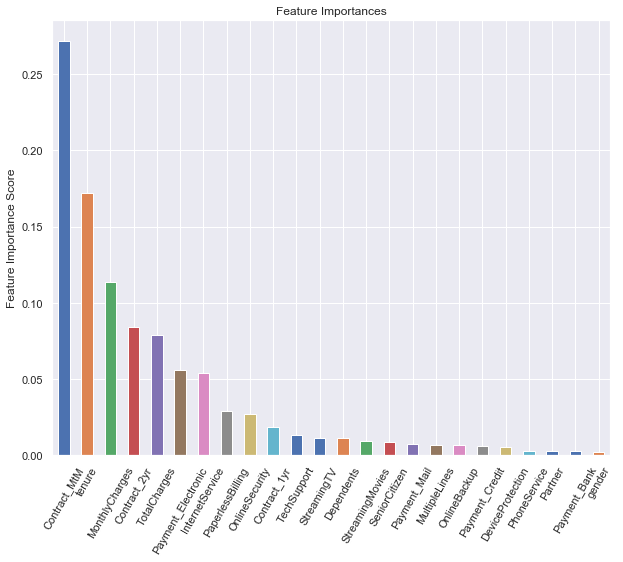

In [131]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    max_depth=6,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features=4
)

grid_classifier(model, train, target, feat_imp=True)

---
### Sklearn GBM
#### Benchmark

Seconds to fit: 2.78
Grid Scores: 

{'mean_fit_time': array([1.07584324]),
 'mean_score_time': array([0.00961895]),
 'mean_test_score': array([0.84466054]),
 'mean_train_score': array([0.87928133]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85454416]),
 'split0_train_score': array([0.87610938]),
 'split1_test_score': array([0.85384407]),
 'split1_train_score': array([0.87869834]),
 'split2_test_score': array([0.83160893]),
 'split2_train_score': array([0.88309174]),
 'split3_test_score': array([0.84276137]),
 'split3_train_score': array([0.87901413]),
 'split4_test_score': array([0.84053832]),
 'split4_train_score': array([0.87949306]),
 'std_fit_time': array([0.2273989]),
 'std_score_time': array([0.00405613]),
 'std_test_score': array([0.0086377]),
 'std_train_score': array([0.0022377])}
Best Model Parameters: {}
Best Model Score: 0.8447


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

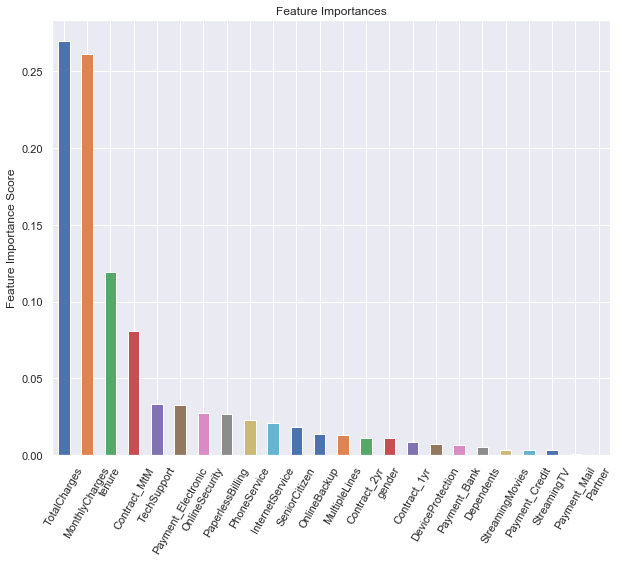

In [133]:
model = GradientBoostingClassifier(random_state=42)

grid_classifier(model, train, target, feat_imp=True)

#### N_estimators

Seconds to fit: 15.04
Grid Scores: 

{'mean_fit_time': array([0.11991143, 0.20558414, 0.29258404, 0.27754002, 0.33128695,
       0.37669439, 0.42653604, 0.45931878, 0.50826621, 0.57230501,
       0.57646871, 0.64216733, 0.71960864, 0.86980939, 0.97021317,
       0.88604307, 0.85352473, 0.90920486, 0.82907162]),
 'mean_score_time': array([0.00457001, 0.00352945, 0.00320163, 0.00321326, 0.00551004,
       0.00367594, 0.00382595, 0.00376005, 0.00385962, 0.00415964,
       0.00427547, 0.00426788, 0.00546217, 0.00553617, 0.00540462,
       0.00551906, 0.00540185, 0.00504284, 0.00414991]),
 'mean_test_score': array([0.83321919, 0.83829934, 0.84142291, 0.84364145, 0.84448586,
       0.84544292, 0.84580038, 0.84606018, 0.84614865, 0.84591209,
       0.84550564, 0.8454096 , 0.84531346, 0.84518349, 0.84513155,
       0.84497948, 0.84469617, 0.84460199, 0.84466054]),
 'mean_train_score': array([0.84222507, 0.84870448, 0.85267935, 0.85654636, 0.85912974,
       0.8612237 , 0.86319185, 0.8649906 , 

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

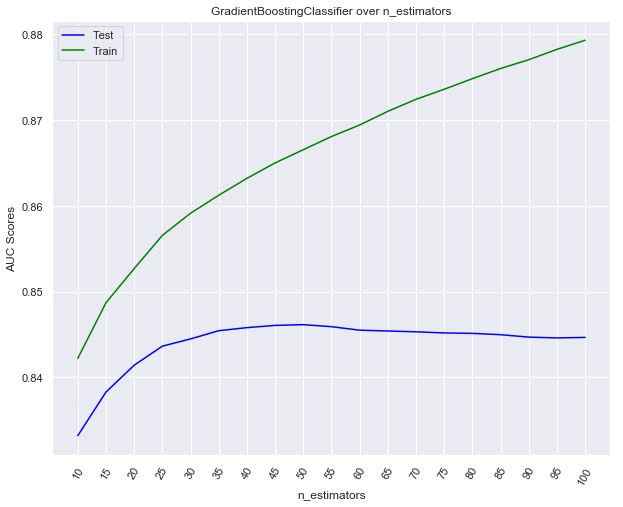

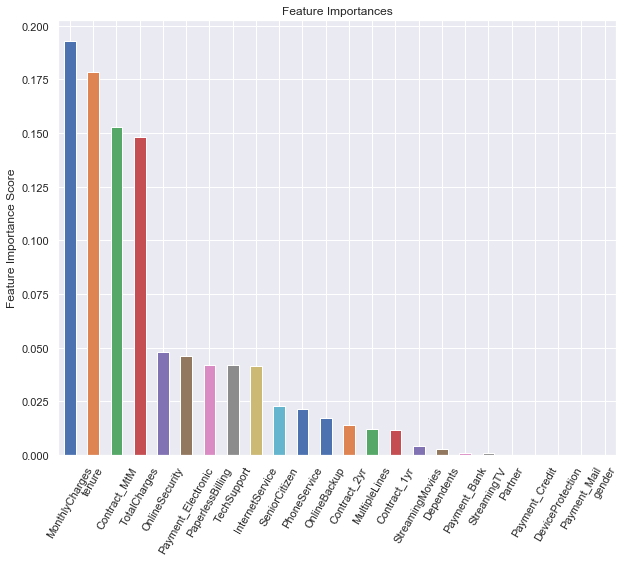

In [136]:
model = GradientBoostingClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth
Leaving this alone, looks like an overfit

Additionally -  I already halved the number of trees, making them all shallow (depth of 3) doesn't make sense.

Seconds to fit: 22.24
Grid Scores: 

{'mean_fit_time': array([0.52954726, 0.92626467, 1.24074049, 1.6304884 , 2.45765486,
       3.22663002, 5.0134758 ]),
 'mean_score_time': array([0.00586295, 0.00496006, 0.00441175, 0.00587168, 0.00644288,
       0.01329632, 0.01132526]),
 'mean_test_score': array([0.84614865, 0.84389189, 0.84180018, 0.8385711 , 0.83299869,
       0.82830311, 0.82386819]),
 'mean_train_score': array([0.86652977, 0.88419333, 0.90959449, 0.93946462, 0.96756668,
       0.98733591, 0.99703871]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 'split0_test_score': array([0

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

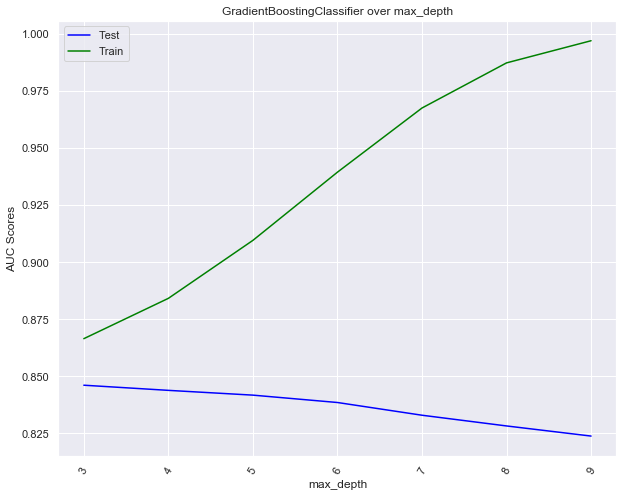

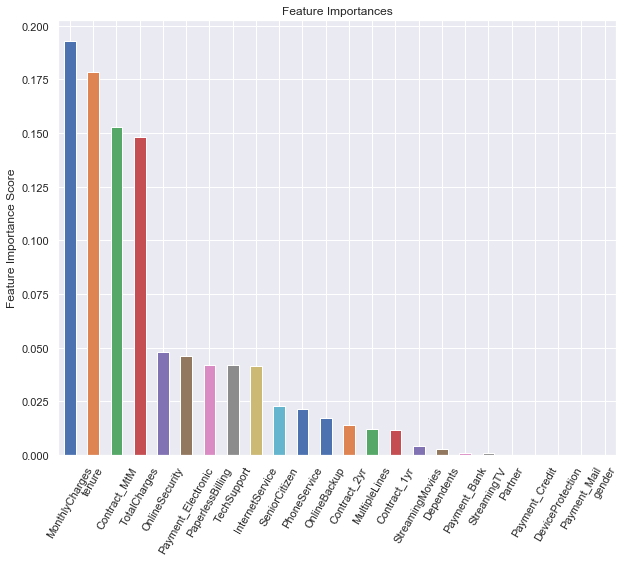

In [138]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'max_depth': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Split
Leaving this alone as well

Seconds to fit: 7.98
Grid Scores: 

{'mean_fit_time': array([0.50849681, 0.5784821 , 0.57437625, 0.55429473, 0.56813583,
       0.53419042, 0.53648386, 0.54988899, 0.51250267, 0.45072379]),
 'mean_score_time': array([0.00525837, 0.00467024, 0.0053225 , 0.00506854, 0.00405521,
       0.00381718, 0.0036757 , 0.00443916, 0.00362592, 0.00309668]),
 'mean_test_score': array([0.84623476, 0.84627377, 0.84626783, 0.84615077, 0.84603526,
       0.84604973, 0.84604973, 0.84605232, 0.84598564, 0.84587866]),
 'mean_train_score': array([0.86630973, 0.86623355, 0.86617209, 0.86607065, 0.86609818,
       0.86622651, 0.86622651, 0.86615605, 0.86613471, 0.8660911 ]),
 'param_min_samples_split': masked_array(data=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_split': 10},
            {'min_samples_split': 20},
            {'m

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': range(10, 101, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

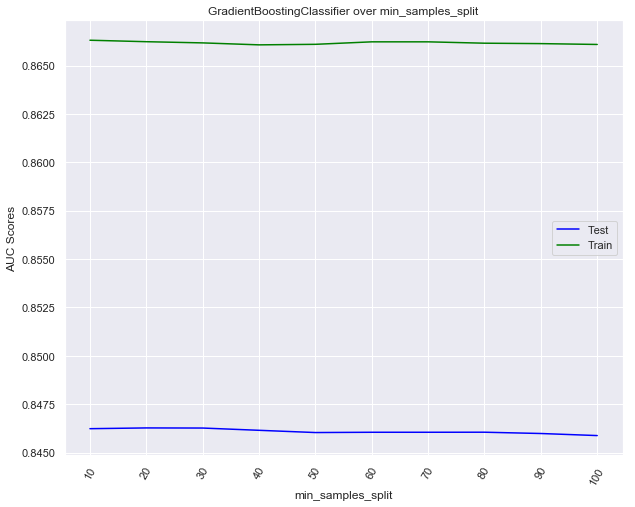

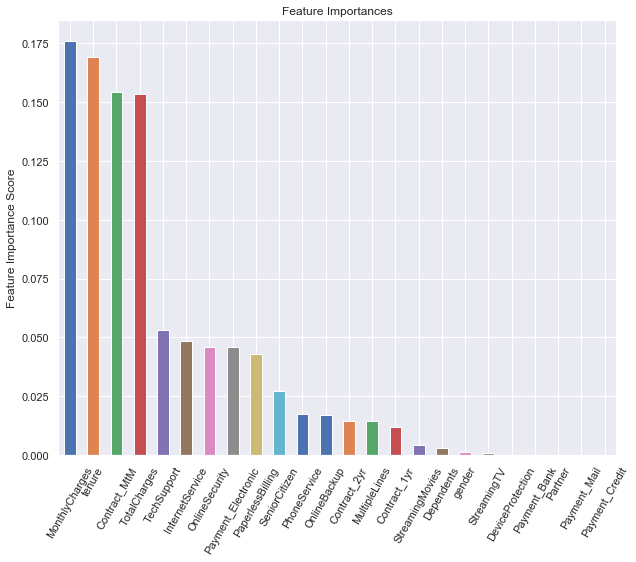

In [140]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_split': range(10, 101, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Samples Leaf

Seconds to fit: 7.99
Grid Scores: 

{'mean_fit_time': array([0.529287  , 0.56194377, 0.51522355, 0.54780812, 0.55448194,
       0.53774505, 0.51203761, 0.58143601, 0.57996817, 0.47307005]),
 'mean_score_time': array([0.00754657, 0.003897  , 0.0052722 , 0.0037137 , 0.00532622,
       0.00442605, 0.00432744, 0.00808105, 0.00321403, 0.00381174]),
 'mean_test_score': array([0.84656335, 0.84680246, 0.84647638, 0.84650264, 0.84656909,
       0.84662448, 0.84663155, 0.84673956, 0.84684511, 0.84727541]),
 'mean_train_score': array([0.86604826, 0.86578113, 0.86557149, 0.86546468, 0.86537905,
       0.86533156, 0.8649416 , 0.8651369 , 0.86490813, 0.8648345 ]),
 'param_min_samples_leaf': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_leaf': 5},
            {'min_samples_leaf': 10},
            {'min_sam

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': range(5, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

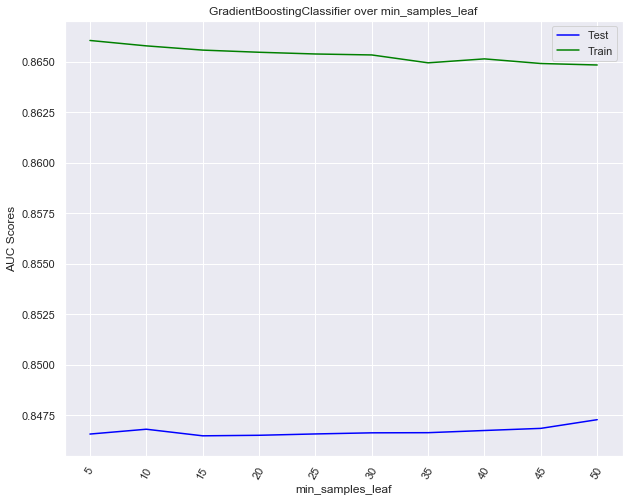

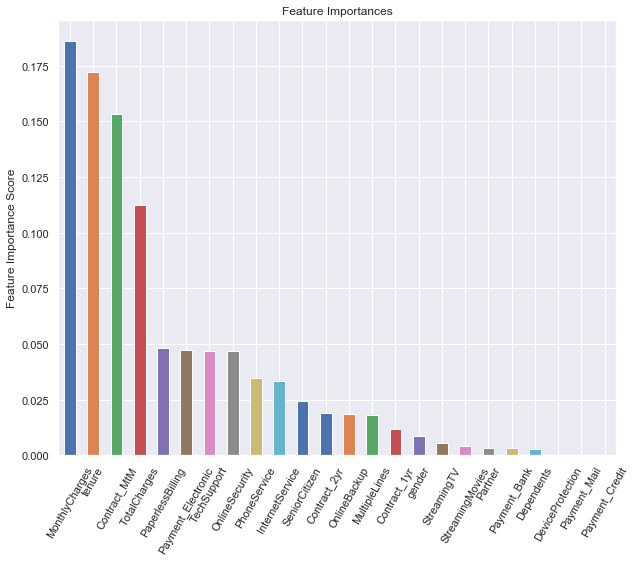

In [142]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50
)

parameters = {'min_samples_leaf': range(5, 51, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Features

Seconds to fit: 2.47
Grid Scores: 

{'mean_fit_time': array([0.19226575, 0.20780201, 0.24549313, 0.25035257, 0.24360719,
       0.24152212]),
 'mean_score_time': array([0.00597177, 0.00481286, 0.00567942, 0.00431552, 0.00368023,
       0.00354648]),
 'mean_test_score': array([0.84716905, 0.84610171, 0.84680547, 0.84730204, 0.84871198,
       0.84795873]),
 'mean_train_score': array([0.86037274, 0.86082579, 0.8609495 , 0.86273296, 0.86315867,
       0.86345482]),
 'param_max_features': masked_array(data=[4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([4, 6, 5, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.86075977, 0.85813118, 0.85992017, 0.86077269, 0.86009197,
       0.860

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(4, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

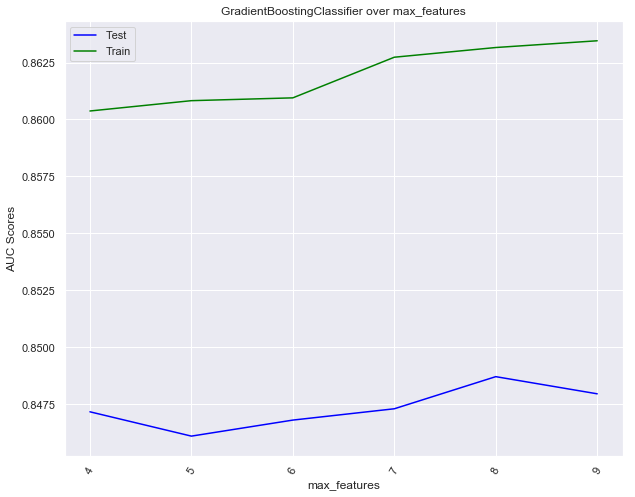

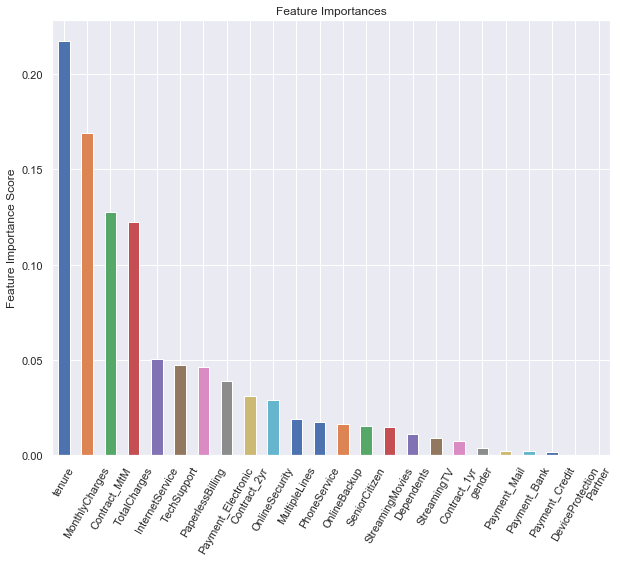

In [144]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
)

parameters = {'max_features': range(4, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate | AUC    |
|--------|-------|------|--------|
| 2/3    | 33    | 1.5  | 0.8474 |
| 1      | 50    | 0.1  | 0.8487 |
| 1.5    | 75    | 0.67 | 0.8481 |
| 2      | 100   | 0.5  | 0.8477 |
| 4      | 200   | 0.25 | 0.8477 |

So it looks like the learning rate didn't need tuning, sticking with default of 0.1

In [152]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=int(50/1.5),
    min_samples_leaf=10,
    max_features=8,
    learning_rate=(0.1*1.5)
)

grid_classifier(model, train, target)

Seconds to fit: 0.70
Grid Scores: 

{'mean_fit_time': array([0.1722302]),
 'mean_score_time': array([0.00412102]),
 'mean_test_score': array([0.84739696]),
 'mean_train_score': array([0.8623024]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85924204]),
 'split0_train_score': array([0.85937105]),
 'split1_test_score': array([0.85591077]),
 'split1_train_score': array([0.85982501]),
 'split2_test_score': array([0.83328037]),
 'split2_train_score': array([0.86681376]),
 'split3_test_score': array([0.84427911]),
 'split3_train_score': array([0.86294017]),
 'split4_test_score': array([0.84426808]),
 'split4_train_score': array([0.862562]),
 'std_fit_time': array([0.03204208]),
 'std_score_time': array([0.00080925]),
 'std_test_score': array([0.00929181]),
 'std_train_score': array([0.00266671])}
Best Model Parameters: {}
Best Model Score: 0.8474


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15000000000000002, loss='deviance',
              max_depth=3, max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=33,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [146]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.1
)

grid_classifier(model, train, target)

Seconds to fit: 0.83
Grid Scores: 

{'mean_fit_time': array([0.23514023]),
 'mean_score_time': array([0.00469499]),
 'mean_test_score': array([0.84871198]),
 'mean_train_score': array([0.86315867]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86009197]),
 'split0_train_score': array([0.86005611]),
 'split1_test_score': array([0.85762484]),
 'split1_train_score': array([0.86091692]),
 'split2_test_score': array([0.83400501]),
 'split2_train_score': array([0.86793362]),
 'split3_test_score': array([0.84530858]),
 'split3_train_score': array([0.86337029]),
 'split4_test_score': array([0.84652641]),
 'split4_train_score': array([0.8635164]),
 'std_fit_time': array([0.03893372]),
 'std_score_time': array([0.00162319]),
 'std_test_score': array([0.00939911]),
 'std_train_score': array([0.00274315])}
Best Model Parameters: {}
Best Model Score: 0.8487


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [149]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=75,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=(0.1/1.5)
)

grid_classifier(model, train, target)

Seconds to fit: 1.23
Grid Scores: 

{'mean_fit_time': array([0.36633515]),
 'mean_score_time': array([0.00520887]),
 'mean_test_score': array([0.84806975]),
 'mean_train_score': array([0.86338863]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85978971]),
 'split0_train_score': array([0.86035913]),
 'split1_test_score': array([0.85678912]),
 'split1_train_score': array([0.86134405]),
 'split2_test_score': array([0.83404635]),
 'split2_train_score': array([0.86781476]),
 'split3_test_score': array([0.84338655]),
 'split3_train_score': array([0.86390053]),
 'split4_test_score': array([0.84633455]),
 'split4_train_score': array([0.86352471]),
 'std_fit_time': array([0.02456905]),
 'std_score_time': array([0.00110278]),
 'std_test_score': array([0.00932849]),
 'std_train_score': array([0.00257796])}
Best Model Parameters: {}
Best Model Score: 0.8481


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.06666666666666667, loss='deviance',
              max_depth=3, max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [147]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.05
)

grid_classifier(model, train, target)

Seconds to fit: 1.52
Grid Scores: 

{'mean_fit_time': array([0.55059738]),
 'mean_score_time': array([0.00987382]),
 'mean_test_score': array([0.84773061]),
 'mean_train_score': array([0.86329907]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85955075]),
 'split0_train_score': array([0.86054182]),
 'split1_test_score': array([0.85583069]),
 'split1_train_score': array([0.86096136]),
 'split2_test_score': array([0.8335723]),
 'split2_train_score': array([0.86747934]),
 'split3_test_score': array([0.84243199]),
 'split3_train_score': array([0.86415013]),
 'split4_test_score': array([0.84726666]),
 'split4_train_score': array([0.86336269]),
 'std_fit_time': array([0.11539692]),
 'std_score_time': array([0.00442255]),
 'std_test_score': array([0.00931878]),
 'std_train_score': array([0.00250081])}
Best Model Parameters: {}
Best Model Score: 0.8477


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [148]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.025
)

grid_classifier(model, train, target)

Seconds to fit: 2.99
Grid Scores: 

{'mean_fit_time': array([1.06987481]),
 'mean_score_time': array([0.01198721]),
 'mean_test_score': array([0.847686]),
 'mean_train_score': array([0.86363468]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85958821]),
 'split0_train_score': array([0.8611982]),
 'split1_test_score': array([0.85633315]),
 'split1_train_score': array([0.86126155]),
 'split2_test_score': array([0.83303495]),
 'split2_train_score': array([0.86776442]),
 'split3_test_score': array([0.84255987]),
 'split3_train_score': array([0.8644946]),
 'split4_test_score': array([0.84691274]),
 'split4_train_score': array([0.86345464]),
 'std_fit_time': array([0.23296013]),
 'std_score_time': array([0.00345684]),
 'std_test_score': array([0.00957176]),
 'std_train_score': array([0.00242466])}
Best Model Parameters: {}
Best Model Score: 0.8477


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final Sklearn GBM Model

Seconds to fit: 0.79
Grid Scores: 

{'mean_fit_time': array([0.2388926]),
 'mean_score_time': array([0.00455875]),
 'mean_test_score': array([0.84871198]),
 'mean_train_score': array([0.86315867]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86009197]),
 'split0_train_score': array([0.86005611]),
 'split1_test_score': array([0.85762484]),
 'split1_train_score': array([0.86091692]),
 'split2_test_score': array([0.83400501]),
 'split2_train_score': array([0.86793362]),
 'split3_test_score': array([0.84530858]),
 'split3_train_score': array([0.86337029]),
 'split4_test_score': array([0.84652641]),
 'split4_train_score': array([0.8635164]),
 'std_fit_time': array([0.04058668]),
 'std_score_time': array([0.00114912]),
 'std_test_score': array([0.00939911]),
 'std_train_score': array([0.00274315])}
Best Model Parameters: {}
Best Model Score: 0.8487


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

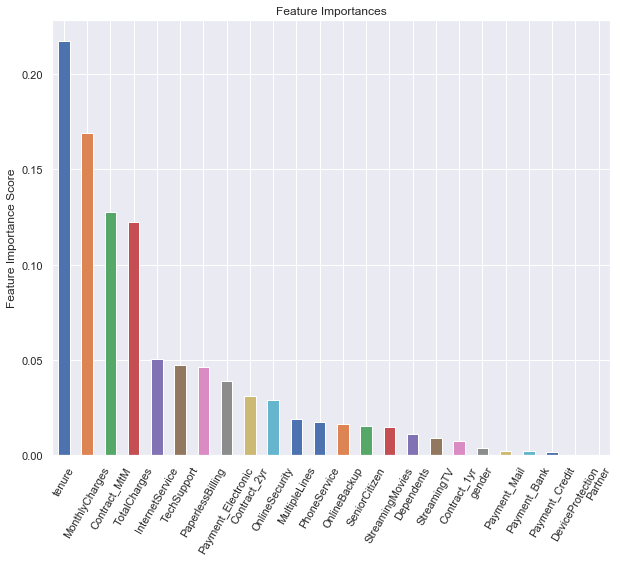

In [153]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.1
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 0.93
Grid Scores: 

{'mean_fit_time': array([0.2414506]),
 'mean_score_time': array([0.00570841]),
 'mean_test_score': array([0.84871198]),
 'mean_train_score': array([0.86315867]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86009197]),
 'split0_train_score': array([0.86005611]),
 'split1_test_score': array([0.85762484]),
 'split1_train_score': array([0.86091692]),
 'split2_test_score': array([0.83400501]),
 'split2_train_score': array([0.86793362]),
 'split3_test_score': array([0.84530858]),
 'split3_train_score': array([0.86337029]),
 'split4_test_score': array([0.84652641]),
 'split4_train_score': array([0.8635164]),
 'std_fit_time': array([0.03565037]),
 'std_score_time': array([0.00181448]),
 'std_test_score': array([0.00939911]),
 'std_train_score': array([0.00274315])}
Best Model Parameters: {}
Best Model Score: 0.8487


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

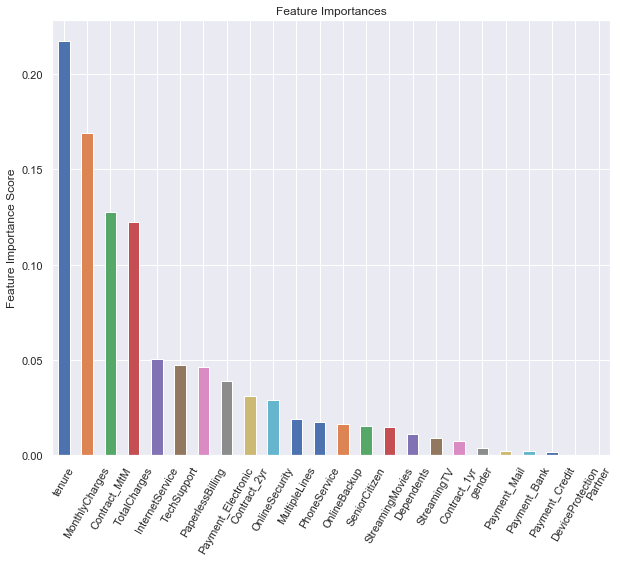

In [161]:
model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_depth=3,
    min_samples_leaf=10,
    max_features=8,
    learning_rate=0.1
)

grid_classifier(model, train, target, feat_imp=True)

---
### XGBoost
#### Benchmark

Seconds to fit: 3.40
Grid Scores: 

{'mean_fit_time': array([1.26849251]),
 'mean_score_time': array([0.00973458]),
 'mean_test_score': array([0.84528427]),
 'mean_train_score': array([0.8743074]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85665607]),
 'split0_train_score': array([0.87193641]),
 'split1_test_score': array([0.85360252]),
 'split1_train_score': array([0.8727687]),
 'split2_test_score': array([0.82938206]),
 'split2_train_score': array([0.87871677]),
 'split3_test_score': array([0.84290604]),
 'split3_train_score': array([0.87455342]),
 'split4_test_score': array([0.84387267]),
 'split4_train_score': array([0.8735617]),
 'std_fit_time': array([0.27059064]),
 'std_score_time': array([0.00207756]),
 'std_test_score': array([0.00958298]),
 'std_train_score': array([0.00236847])}
Best Model Parameters: {}
Best Model Score: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

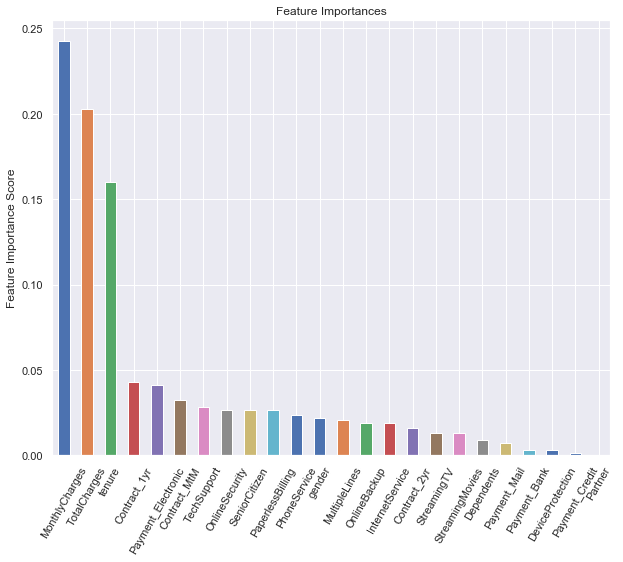

In [156]:
model = XGBClassifier(random_state=42)

grid_classifier(model, train, target, feat_imp=True)

#### N_estimators

Seconds to fit: 21.86
Grid Scores: 

{'mean_fit_time': array([0.15857258, 0.23040786, 0.31677418, 0.53151965, 0.4733263 ,
       0.56678457, 0.60543513, 0.65903263, 0.71126366, 0.78292851,
       0.88872461, 0.94314804, 0.9977716 , 1.18789744, 1.21586108,
       1.29236355, 1.33121767, 1.44353104, 1.25225463]),
 'mean_score_time': array([0.00659518, 0.00734978, 0.00705943, 0.01194816, 0.00781236,
       0.00678482, 0.00636764, 0.00872841, 0.00848136, 0.00864983,
       0.00835738, 0.0156776 , 0.00935397, 0.0092051 , 0.00809379,
       0.01050429, 0.00993857, 0.01151791, 0.00818162]),
 'mean_test_score': array([0.83200397, 0.83642764, 0.83882697, 0.84174957, 0.84330343,
       0.84445279, 0.8454996 , 0.84603891, 0.84643756, 0.8465486 ,
       0.84662423, 0.84637373, 0.84633562, 0.84598271, 0.84581798,
       0.84578349, 0.84576913, 0.84540681, 0.84528427]),
 'mean_train_score': array([0.84010688, 0.84561103, 0.84949363, 0.85298783, 0.85557229,
       0.85807415, 0.86000457, 0.86179908, 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(10, 101, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

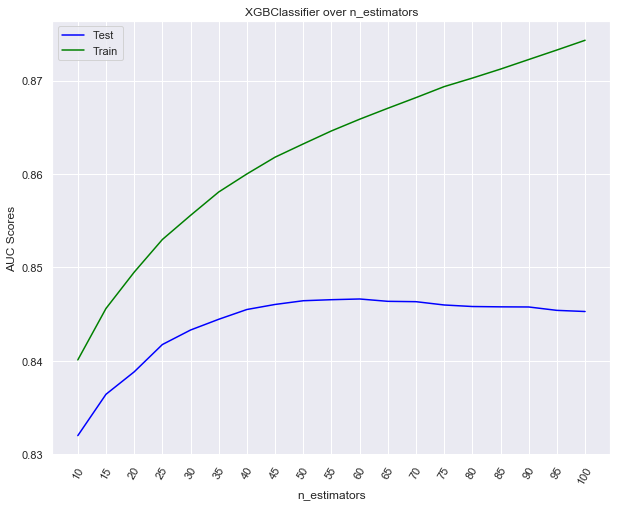

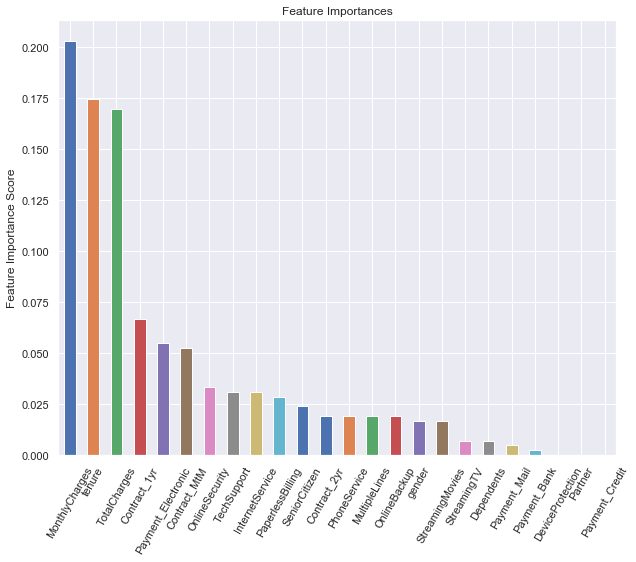

In [159]:
model = XGBClassifier(random_state=42)

parameters = {'n_estimators': range(10, 101, 5)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Max Depth
Sticking with default value of 3

Seconds to fit: 13.66
Grid Scores: 

{'mean_fit_time': array([0.71237898, 0.97635479, 1.14920778, 1.65718818, 1.57309141,
       1.65449419, 1.80935664]),
 'mean_score_time': array([0.00923285, 0.00750341, 0.0084785 , 0.01380882, 0.01174417,
       0.01167188, 0.01277213]),
 'mean_test_score': array([0.84643756, 0.8456868 , 0.84314096, 0.84059448, 0.83615426,
       0.83256413, 0.82680019]),
 'mean_train_score': array([0.86321828, 0.87647087, 0.89408179, 0.91691455, 0.94122549,
       0.96233999, 0.97757989]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 'split0_test_score': array([0

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

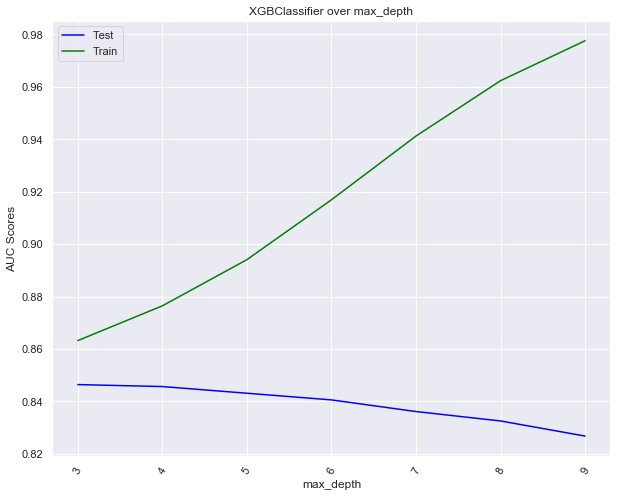

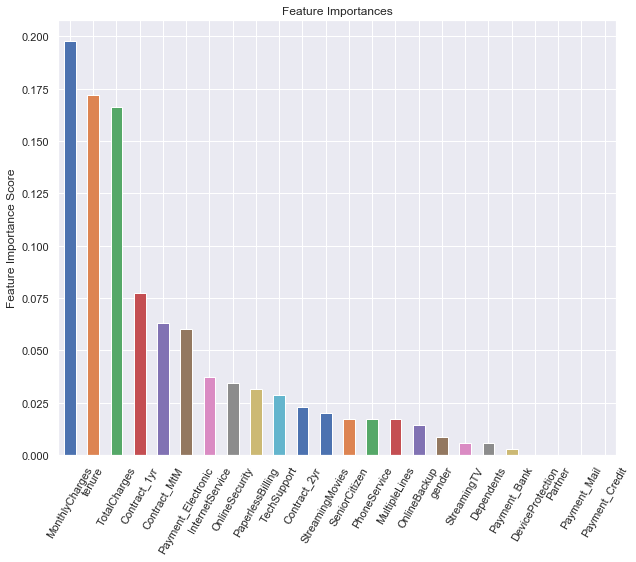

In [162]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50
)
    
parameters = {'max_depth': range(3, 10)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Min Child Weight

Seconds to fit: 7.94
Grid Scores: 

{'mean_fit_time': array([0.88337903, 0.76496711, 0.78267446, 0.75061574, 0.71858697,
       0.74641061, 0.64365516]),
 'mean_score_time': array([0.01408515, 0.00642056, 0.00785718, 0.0064827 , 0.00974197,
       0.00777974, 0.00782218]),
 'mean_test_score': array([0.84643756, 0.84620952, 0.84642939, 0.84634716, 0.84627098,
       0.8467424 , 0.84667128]),
 'mean_train_score': array([0.86321828, 0.86331124, 0.86308072, 0.86297696, 0.86302081,
       0.86305656, 0.8632712 ]),
 'param_min_child_weight': masked_array(data=[1, 2, 3, 4, 5, 6, 7],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_child_weight': 1},
            {'min_child_weight': 2},
            {'min_child_weight': 3},
            {'min_child_weight': 4},
            {'min_child_weight': 5},
            {'min_child_weight': 6},
            {'min_child_weight': 7}],
 'rank_test_score': array([3, 7, 4, 5,

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': range(1, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

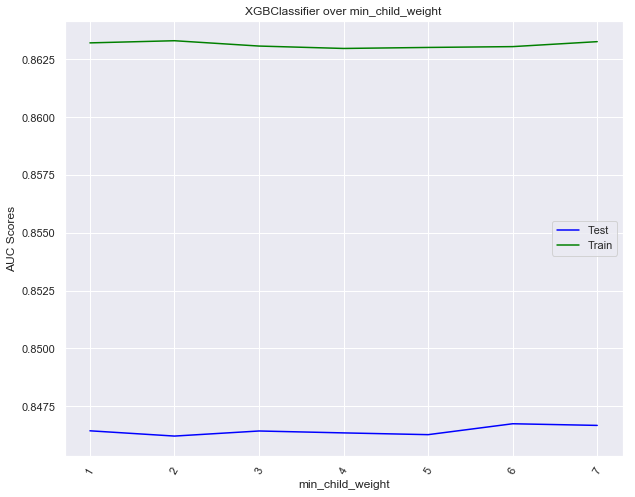

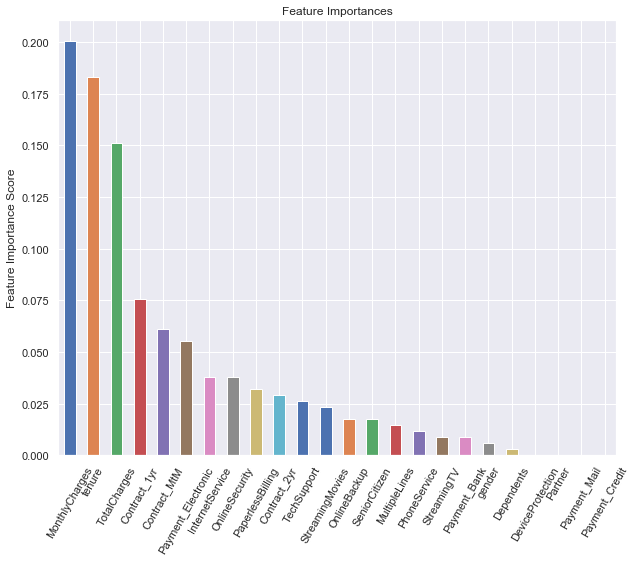

In [163]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50
)
    
parameters = {'min_child_weight': range(1, 8)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Subsample

Seconds to fit: 11.36
Grid Scores: 

{'mean_fit_time': array([0.71424131, 0.80660343, 0.69693685, 0.68832293, 0.67815504,
       0.6889277 , 0.69474154, 0.68091564, 0.79345164, 0.74439802,
       0.59511638]),
 'mean_score_time': array([0.00907078, 0.00809083, 0.00697742, 0.00627332, 0.00711231,
       0.00656757, 0.00693398, 0.00607371, 0.00719414, 0.0079113 ,
       0.00537367]),
 'mean_test_score': array([0.84702223, 0.84711714, 0.84849564, 0.84622768, 0.84744584,
       0.84722171, 0.84761848, 0.84693596, 0.84730011, 0.84699985,
       0.8467424 ]),
 'mean_train_score': array([0.86252278, 0.86263607, 0.86298523, 0.86287641, 0.86304759,
       0.86309157, 0.86310658, 0.86325535, 0.86310041, 0.86312272,
       0.86305656]),
 'param_subsample': masked_array(data=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8,
                   0.8500000000000001, 0.9, 0.95, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_val

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

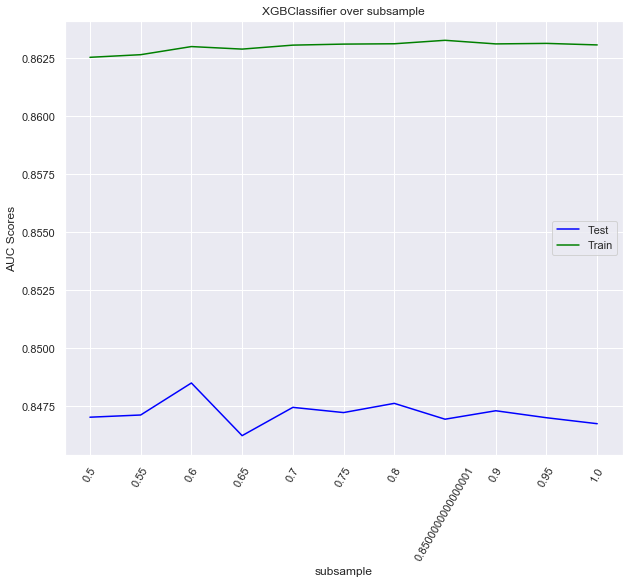

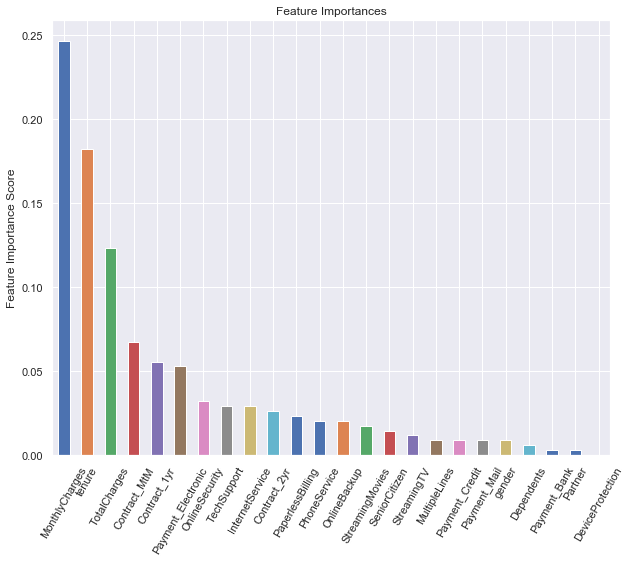

In [168]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50,
    min_child_weight=6
)
    
parameters = {'subsample': np.linspace(0.5, 1.0, 11)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Col Sample By Tree
Tempting to pick 0.5 but sticking with 1.0

Seconds to fit: 11.19
Grid Scores: 

{'mean_fit_time': array([0.47621374, 0.48881884, 0.51783338, 0.55213161, 0.56699991,
       0.56080093, 0.62147417, 0.58996525, 0.6036232 , 0.61996217,
       0.64992576, 0.6708045 , 0.61545553]),
 'mean_score_time': array([0.00860262, 0.00770173, 0.00806007, 0.00779138, 0.00725837,
       0.00666084, 0.00948029, 0.00743279, 0.00733685, 0.00698423,
       0.00649381, 0.00651574, 0.00568423]),
 'mean_test_score': array([0.84794459, 0.84754907, 0.84844258, 0.84712588, 0.84738928,
       0.84736981, 0.84774063, 0.8476276 , 0.84821371, 0.84789012,
       0.84783245, 0.84782661, 0.84849564]),
 'mean_train_score': array([0.85972278, 0.86025582, 0.86126329, 0.86105983, 0.8614397 ,
       0.86159181, 0.86175526, 0.86173629, 0.86206797, 0.86221402,
       0.86204232, 0.86227009, 0.86298523]),
 'param_colsample_bytree': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,
                   0.8999999999999999, 0.95, 1.0],
             mas

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ,
       0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

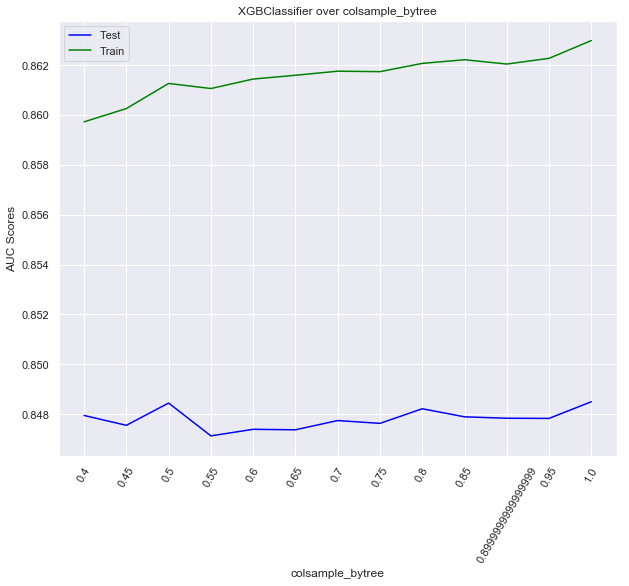

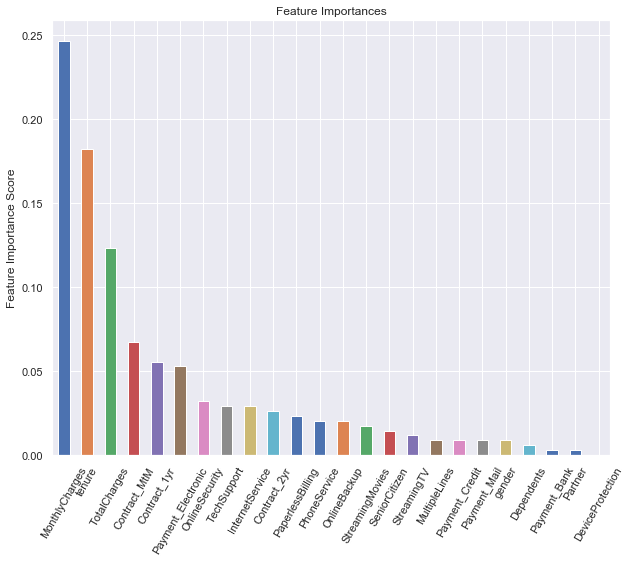

In [170]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50,
    min_child_weight=6,
    subsample=0.6
)
    
parameters = {'colsample_bytree': np.linspace(0.4, 1.0, 13)}

grid_classifier(model, train, target, parameters, feat_imp=True)

Seconds to fit: 10.99
Grid Scores: 

{'mean_fit_time': array([0.48606606, 0.74461503, 0.71605539, 0.69903364, 0.70795059,
       0.72569318, 0.70585728, 0.74121208, 0.70157876, 0.72090244,
       0.60500536]),
 'mean_score_time': array([0.01143379, 0.00662556, 0.00610409, 0.01052957, 0.00823889,
       0.007621  , 0.00830197, 0.0071032 , 0.00918779, 0.00886316,
       0.00526819]),
 'mean_test_score': array([0.5       , 0.84468024, 0.84772666, 0.84793769, 0.84741489,
       0.84857498, 0.84834423, 0.84859198, 0.84785562, 0.84756117,
       0.84849564]),
 'mean_train_score': array([0.5       , 0.85233941, 0.85714657, 0.85906862, 0.86019041,
       0.86121889, 0.86198914, 0.8622791 , 0.86249169, 0.86269082,
       0.86298523]),
 'param_scale_pos_weight': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                   0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   Fal

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scale_pos_weight': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

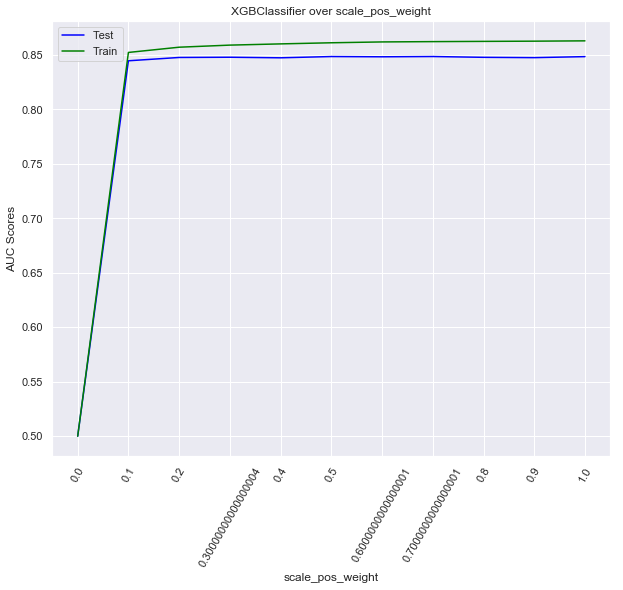

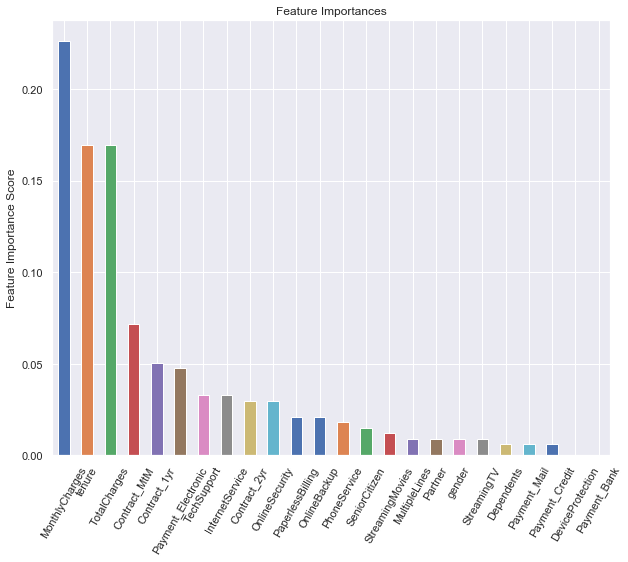

In [171]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50,
    min_child_weight=6,
    subsample=0.6
)
    
parameters = {'scale_pos_weight': np.arange(0.0, 1.1, 0.1)}

grid_classifier(model, train, target, parameters, feat_imp=True)

#### Learning Rate
Increase and decrease the learning rate in proportion to the trees. 

Results:

| factor | trees | rate | AUC    |
|--------|-------|------|--------|
| 2/3    | 33    | 1.5  | 0.8477 |
| 1      | 50    | 0.1  | 0.8485 |
| 1.5    | 75    | 0.67 | 0.8480 |
| 2      | 100   | 0.5  | 0.8485 |
| 4      | 200   | 0.25 | 0.8484 |

Once again, the learning rate didn't need tuning, sticking with default of 0.1

Seconds to fit: 1.38
Grid Scores: 

{'mean_fit_time': array([0.45380883]),
 'mean_score_time': array([0.0138073]),
 'mean_test_score': array([0.84771931]),
 'mean_train_score': array([0.8617475]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86053373]),
 'split0_train_score': array([0.85939982]),
 'split1_test_score': array([0.85637319]),
 'split1_train_score': array([0.85918593]),
 'split2_test_score': array([0.8313183]),
 'split2_train_score': array([0.86523355]),
 'split3_test_score': array([0.84352605]),
 'split3_train_score': array([0.86234384]),
 'split4_test_score': array([0.84684403]),
 'split4_train_score': array([0.86257435]),
 'std_fit_time': array([0.07877007]),
 'std_score_time': array([0.00705094]),
 'std_test_score': array([0.01026246]),
 'std_train_score': array([0.00224789])}
Best Model Parameters: {}
Best Model Score: 0.8477


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=33,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

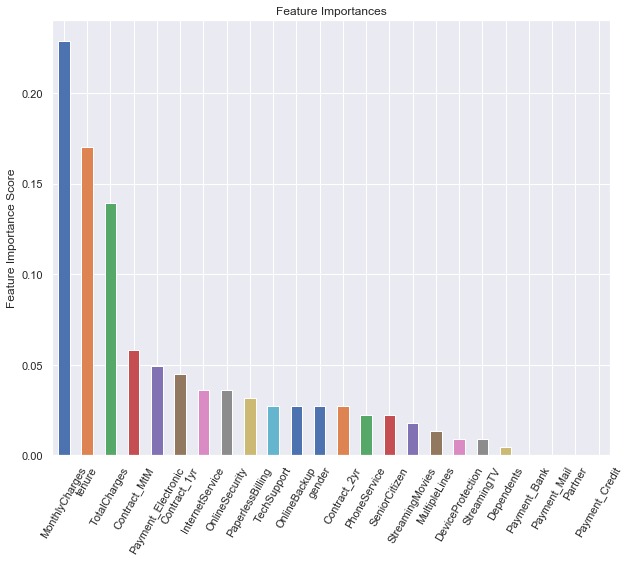

In [174]:
model = XGBClassifier(
    random_state=42,
    n_estimators=int(50/1.5),
    min_child_weight=6,
    subsample=0.6,
    learning_rate=0.15
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 2.06
Grid Scores: 

{'mean_fit_time': array([0.70685558]),
 'mean_score_time': array([0.0095561]),
 'mean_test_score': array([0.84849564]),
 'mean_train_score': array([0.86298523]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85956367]),
 'split0_train_score': array([0.86039339]),
 'split1_test_score': array([0.85944483]),
 'split1_train_score': array([0.86095118]),
 'split2_test_score': array([0.83117492]),
 'split2_train_score': array([0.86709795]),
 'split3_test_score': array([0.84530083]),
 'split3_train_score': array([0.86308263]),
 'split4_test_score': array([0.84699182]),
 'split4_train_score': array([0.86340103]),
 'std_fit_time': array([0.14217557]),
 'std_score_time': array([0.00251524]),
 'std_test_score': array([0.01053581]),
 'std_train_score': array([0.0023644])}
Best Model Parameters: {}
Best Model Score: 0.8485


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

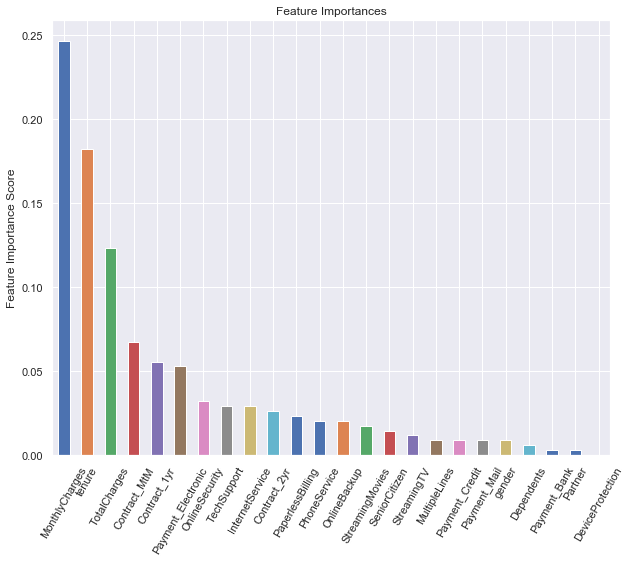

In [173]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50,
    min_child_weight=6,
    subsample=0.6,
    learning_rate=0.1
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 2.87
Grid Scores: 

{'mean_fit_time': array([0.99172225]),
 'mean_score_time': array([0.0083746]),
 'mean_test_score': array([0.84797604]),
 'mean_train_score': array([0.86276864]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86087861]),
 'split0_train_score': array([0.86046627]),
 'split1_test_score': array([0.85831719]),
 'split1_train_score': array([0.86084048]),
 'split2_test_score': array([0.83186727]),
 'split2_train_score': array([0.86663227]),
 'split3_test_score': array([0.84342013]),
 'split3_train_score': array([0.86290195]),
 'split4_test_score': array([0.84539336]),
 'split4_train_score': array([0.86300222]),
 'std_fit_time': array([0.17712759]),
 'std_score_time': array([0.00202274]),
 'std_test_score': array([0.01058758]),
 'std_train_score': array([0.00219174])}
Best Model Parameters: {}
Best Model Score: 0.8480


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.06666666666666667,
       max_delta_step=0, max_depth=3, min_child_weight=6, missing=None,
       n_estimators=75, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

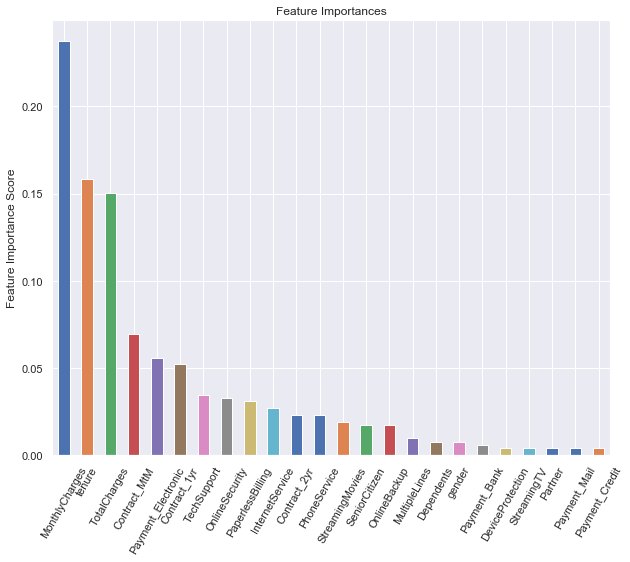

In [176]:
model = XGBClassifier(
    random_state=42,
    n_estimators=75,
    min_child_weight=6,
    subsample=0.6,
    learning_rate=(0.1/1.5)
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 3.70
Grid Scores: 

{'mean_fit_time': array([1.40724006]),
 'mean_score_time': array([0.01865997]),
 'mean_test_score': array([0.84853748]),
 'mean_train_score': array([0.86303539]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86090057]),
 'split0_train_score': array([0.86047556]),
 'split1_test_score': array([0.8582526]),
 'split1_train_score': array([0.86124013]),
 'split2_test_score': array([0.83170839]),
 'split2_train_score': array([0.8670169]),
 'split3_test_score': array([0.8443114]),
 'split3_train_score': array([0.86353295]),
 'split4_test_score': array([0.84751298]),
 'split4_train_score': array([0.8629114]),
 'std_fit_time': array([0.28876506]),
 'std_score_time': array([0.00593953]),
 'std_test_score': array([0.01048343]),
 'std_train_score': array([0.00227557])}
Best Model Parameters: {}
Best Model Score: 0.8485


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

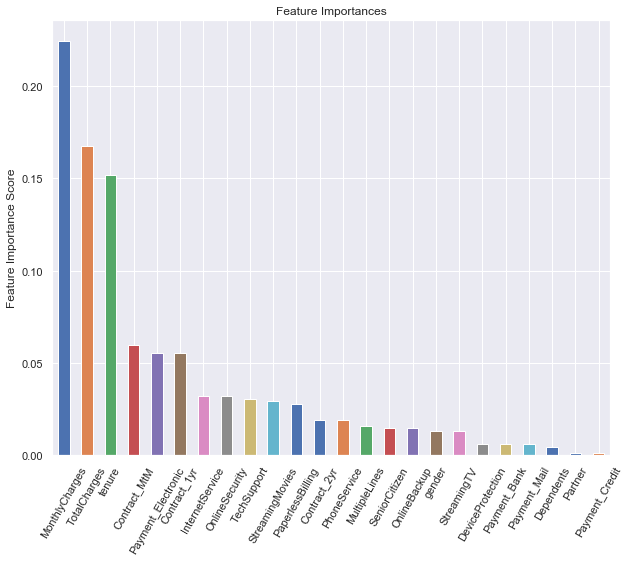

In [177]:
model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    min_child_weight=6,
    subsample=0.6,
    learning_rate=0.05
)

grid_classifier(model, train, target, feat_imp=True)

Seconds to fit: 8.42
Grid Scores: 

{'mean_fit_time': array([3.40236592]),
 'mean_score_time': array([0.02369075]),
 'mean_test_score': array([0.84838277]),
 'mean_train_score': array([0.86337965]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.86074556]),
 'split0_train_score': array([0.86094156]),
 'split1_test_score': array([0.8581596]),
 'split1_train_score': array([0.86171195]),
 'split2_test_score': array([0.83232323]),
 'split2_train_score': array([0.86732872]),
 'split3_test_score': array([0.84416156]),
 'split3_train_score': array([0.86351259]),
 'split4_test_score': array([0.84652123]),
 'split4_train_score': array([0.86340346]),
 'std_fit_time': array([0.70001449]),
 'std_score_time': array([0.00711403]),
 'std_test_score': array([0.01027388]),
 'std_train_score': array([0.00220631])}
Best Model Parameters: {}
Best Model Score: 0.8484


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.025, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

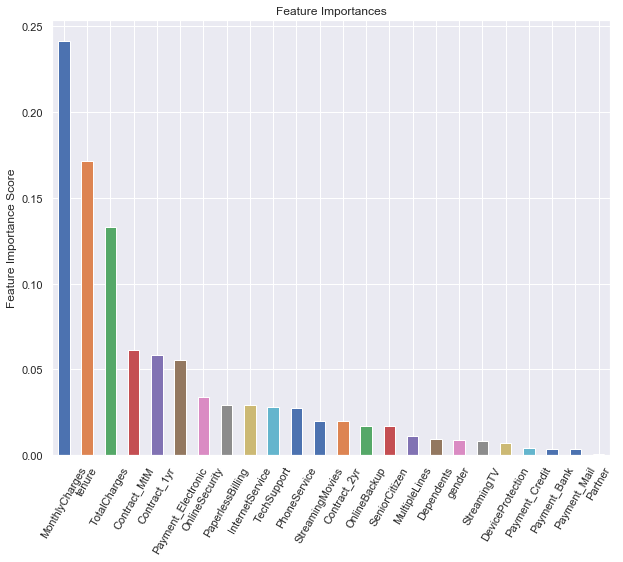

In [178]:
model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    min_child_weight=6,
    subsample=0.6,
    learning_rate=0.025
)

grid_classifier(model, train, target, feat_imp=True)

#### Final XGBoost Model

Seconds to fit: 2.12
Grid Scores: 

{'mean_fit_time': array([0.75328455]),
 'mean_score_time': array([0.00956364]),
 'mean_test_score': array([0.84849564]),
 'mean_train_score': array([0.86298523]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.85956367]),
 'split0_train_score': array([0.86039339]),
 'split1_test_score': array([0.85944483]),
 'split1_train_score': array([0.86095118]),
 'split2_test_score': array([0.83117492]),
 'split2_train_score': array([0.86709795]),
 'split3_test_score': array([0.84530083]),
 'split3_train_score': array([0.86308263]),
 'split4_test_score': array([0.84699182]),
 'split4_train_score': array([0.86340103]),
 'std_fit_time': array([0.15444386]),
 'std_score_time': array([0.00387417]),
 'std_test_score': array([0.01053581]),
 'std_train_score': array([0.0023644])}
Best Model Parameters: {}
Best Model Score: 0.8485


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=6, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

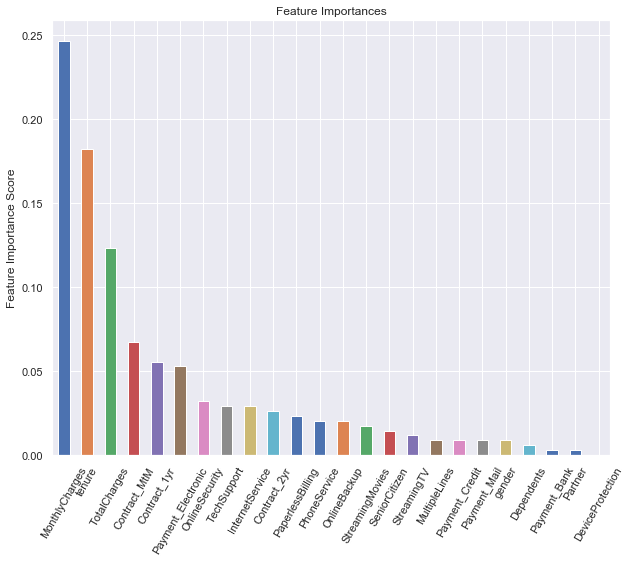

In [179]:
model = XGBClassifier(
    random_state=42,
    n_estimators=50,
    min_child_weight=6,
    subsample=0.6,
    learning_rate=0.1
)

grid_classifier(model, train, target, feat_imp=True)